## FCN with VGG19 for encoder and Deconvolutional Decoder layers with weighted Cross Entropy

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix

In [0]:
class Segmentor(nn.Module):
    """
    FCN: fully convolutional network with VGG-19 backbone.
    """

    def __init__(self, num_classes,medical=True):
        super().__init__()
        # pre-trained features
        vgg19 = models.vgg19(pretrained=True)
        backbone = vgg19.features
        
        # Modify conv1_1 to have 4 input channels
        # Init the weights in the new channels to the channel-wise mean
        # of the pre-trained conv1_1 weights
        if medical==True:
            old_conv1 = backbone[0].weight.data
            mean_conv1 = torch.mean(old_conv1, dim=1, keepdim=True)
            new_conv1 = nn.Conv2d(4, old_conv1.size(0), kernel_size=old_conv1.size(2), stride=1, padding=1)
            new_conv1.weight.data =torch.cat([old_conv1, mean_conv1], dim=1)
            new_conv1.bias.data = backbone[0].bias.data
            backbone[0] = new_conv1
        
        
        #pre trained features
        self.encoder = copy.deepcopy(backbone)

        # classifier head
        self.head = nn.Conv2d(512, num_classes, 1)
        torch.nn.init.xavier_uniform_(self.head.weight)
        self.head.bias.data.fill_(0.)

        self.decoder = nn.Sequential(nn.ConvTranspose2d(num_classes,2*num_classes,3,stride=3),
                                    nn.ConvTranspose2d(2*num_classes,4*num_classes,3,stride=2),
                                    nn.ConvTranspose2d(4*num_classes,2*num_classes,3,stride=2),
                                    nn.ConvTranspose2d(2*num_classes,num_classes,3,stride=2))
        self.encoder[0].padding = (81, 81)
        
    def forward(self, x):
        h, w = x.size()[-2:]

        x = self.encoder(x)
        x = self.head(x)
        x = self.decoder(x)
        
        # crop outouput to input size
        H,W=x.size()[-2:]
        startx = H//2 - h//2
        starty = W//2 - w//2  
        x = x[:,:,startx:startx + h, starty:starty + w]

        return x

In [0]:
class weightedCrossEntropy(nn.CrossEntropyLoss):
    """
    Frequency weighting for imbalanced classes
        prediction: shape N x C x H x W
        ground_truth: shape N x 1 x H x W
    """

    def forward(self, prediction, ground_truths, weights):
    
        _, c, _, _ = prediction.size()
        prediction = prediction.permute(0, 2, 3, 1).contiguous().view(-1, c)
        ground_truth = ground_truths.view(-1)
        return F.cross_entropy(prediction, ground_truth, weight=weights, size_average=True)

In [0]:
def Metrics(seg,target,certainity=1e-1):
    # get the quanitative results of the segmentation
    # calculate the IOU and Accuracy
    # use Confusion matrix to get TP,TN,FP,FN
    pred=(seg>certainity).flatten()
    true=(target>0).flatten()
    ConfMatrix=confusion_matrix(true,pred)

    TP=ConfMatrix[1,1]
    TN=ConfMatrix[0,0]
    FP=ConfMatrix[0,1]
    FN=ConfMatrix[1,0]

    print("Accuracy(%):","{:.4f}".format(100*(TP+TN)/(TP+TN+FP+FN)))
    print("IoU(%)     :","{:.4f}".format(100*(TP)/(TP+FP+FN)))
    
    return

In [0]:
seed=136
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Load Data

The split used is train:70pc val:10pc test:20pc 

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [10]:
path='./drive/My Drive/dataPreprocessed/'
view='coronal'

print('Preparing training data...')
train_ds, test_ds, val_ds =dataloader.prepare_data(path, view, testSplit=0.2, valSplit=0.1)
print('Loaded dataset...')
print('TRAIN:',len(train_ds))
print('VAL  :',len(val_ds))
print('TEST :',len(test_ds))

Preparing training data...
Loaded dataset...
TRAIN: 2163
VAL  : 308
TEST : 617


# Verify Loaded Data

* expected inputs and target shape and type
* visualise the inputs and target

In [11]:
for i, data in enumerate(train_ds):
    inputs, target, count=data
    print(inputs.shape,target.shape, count)
    break

torch.Size([1, 4, 230, 230]) torch.Size([1, 1, 230, 230]) tensor([0])


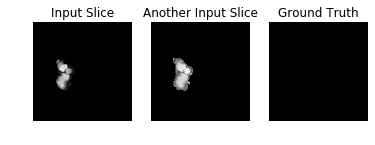

In [12]:
plt.subplot(131)
plt.title('Input Slice')
plt.imshow(inputs[0,0,:,:,],cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title('Another Input Slice')
plt.imshow(inputs[0,2,:,:,],cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title('Ground Truth')
plt.imshow(target[0,0,:,:],cmap='gray')
plt.axis('off')

plt.show()

# Training

* Load the FCN segmentor for 2 class problem
* Load the weighted crossEntropy Loss function
* Set Optimiser and lr


In [0]:
model=Segmentor(num_classes=2).cuda()
lossFN=weightedCrossEntropy()

In [0]:
learned_params = filter(lambda p: p.requires_grad, model.parameters())
opt = optim.Adam(learned_params,lr=1e-5)

In [0]:
def checkValidationSet(model,val_ds):
    # get the validation result
    valLoss=[]
    
    # freeze model weights
    model.eval()
    for i, data in enumerate(val_ds):
        inputs, target, count=data

        pred=model(Variable(inputs).cuda())
        classFreq=(count.numpy()/(inputs.shape[-1]*inputs.shape[-2]))
        class_weights=torch.FloatTensor([1/(1-classFreq),1/classFreq]).cuda()
        loss=lossFN(pred,target.long().cuda(),class_weights)
        valLoss.append(loss.data.cpu())

    return sum(valLoss)/len(valLoss)

In [0]:
# no of epochs to train
epochs=10
trainLoss=[]
valLoss=[]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


EPOCH: 1 INSTANCE: 1
weighted CE LOSS: 0.00077171973

EPOCH: 1 INSTANCE: 2
weighted CE LOSS: 0.013017082

EPOCH: 1 INSTANCE: 3
weighted CE LOSS: 0.007102995

EPOCH: 1 INSTANCE: 4
weighted CE LOSS: 0.016337875

EPOCH: 1 INSTANCE: 5
weighted CE LOSS: 0.10184683

EPOCH: 1 INSTANCE: 6
weighted CE LOSS: 0.0008763391

EPOCH: 1 INSTANCE: 7
weighted CE LOSS: 0.080636606

EPOCH: 1 INSTANCE: 8
weighted CE LOSS: 0.06831353

EPOCH: 1 INSTANCE: 9
weighted CE LOSS: 0.0019793927

EPOCH: 1 INSTANCE: 10
weighted CE LOSS: 0.00077350787

EPOCH: 1 INSTANCE: 11
weighted CE LOSS: 0.07283867

EPOCH: 1 INSTANCE: 12
weighted CE LOSS: 0.14017236

EPOCH: 1 INSTANCE: 13
weighted CE LOSS: 0.030698469

EPOCH: 1 INSTANCE: 14
weighted CE LOSS: 0.10441269

EPOCH: 1 INSTANCE: 15
weighted CE LOSS: 0.098405115

EPOCH: 1 INSTANCE: 16
weighted CE LOSS: 0.0016348073

EPOCH: 1 INSTANCE: 17
weighted CE LOSS: 0.0007309231

EPOCH: 1 INSTANCE: 18
weighted CE LOSS: 0.044964056

EPOCH: 1 INSTANCE: 19
weighted CE LOSS: 0.0012873717

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


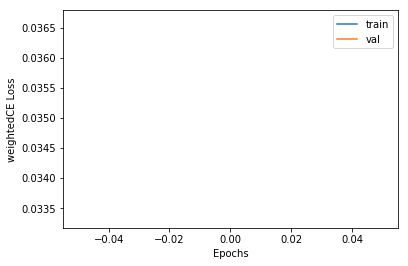

EPOCH: 2 INSTANCE: 1
weighted CE LOSS: 9.985126e-05

EPOCH: 2 INSTANCE: 2
weighted CE LOSS: 0.0028289529

EPOCH: 2 INSTANCE: 3
weighted CE LOSS: 0.00013384352

EPOCH: 2 INSTANCE: 4
weighted CE LOSS: 6.640292e-05

EPOCH: 2 INSTANCE: 5
weighted CE LOSS: 0.024281755

EPOCH: 2 INSTANCE: 6
weighted CE LOSS: 0.054177113

EPOCH: 2 INSTANCE: 7
weighted CE LOSS: 0.017434252

EPOCH: 2 INSTANCE: 8
weighted CE LOSS: 3.0106195e-05

EPOCH: 2 INSTANCE: 9
weighted CE LOSS: 0.00014837111

EPOCH: 2 INSTANCE: 10
weighted CE LOSS: 1.44808755e-05

EPOCH: 2 INSTANCE: 11
weighted CE LOSS: 4.8924736e-05

EPOCH: 2 INSTANCE: 12
weighted CE LOSS: 0.03776168

EPOCH: 2 INSTANCE: 13
weighted CE LOSS: 0.00022860046

EPOCH: 2 INSTANCE: 14
weighted CE LOSS: 3.8914735e-05

EPOCH: 2 INSTANCE: 15
weighted CE LOSS: 0.041336957

EPOCH: 2 INSTANCE: 16
weighted CE LOSS: 0.08200621

EPOCH: 2 INSTANCE: 17
weighted CE LOSS: 4.8476762e-05

EPOCH: 2 INSTANCE: 18
weighted CE LOSS: 0.06032445

EPOCH: 2 INSTANCE: 19
weighted CE LOSS

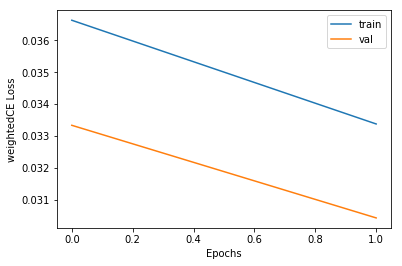

EPOCH: 3 INSTANCE: 1
weighted CE LOSS: 0.08412273

EPOCH: 3 INSTANCE: 2
weighted CE LOSS: 7.85031e-06

EPOCH: 3 INSTANCE: 3
weighted CE LOSS: 0.057953108

EPOCH: 3 INSTANCE: 4
weighted CE LOSS: 2.6247506e-05

EPOCH: 3 INSTANCE: 5
weighted CE LOSS: 0.10503014

EPOCH: 3 INSTANCE: 6
weighted CE LOSS: 7.093215e-05

EPOCH: 3 INSTANCE: 7
weighted CE LOSS: 0.004633696

EPOCH: 3 INSTANCE: 8
weighted CE LOSS: 1.2633161e-05

EPOCH: 3 INSTANCE: 9
weighted CE LOSS: 0.059146482

EPOCH: 3 INSTANCE: 10
weighted CE LOSS: 1.218022e-05

EPOCH: 3 INSTANCE: 11
weighted CE LOSS: 0.067788616

EPOCH: 3 INSTANCE: 12
weighted CE LOSS: 2.2187316e-05

EPOCH: 3 INSTANCE: 13
weighted CE LOSS: 9.6186355e-05

EPOCH: 3 INSTANCE: 14
weighted CE LOSS: 0.0015340064

EPOCH: 3 INSTANCE: 15
weighted CE LOSS: 4.6021e-05

EPOCH: 3 INSTANCE: 16
weighted CE LOSS: 7.715584e-06

EPOCH: 3 INSTANCE: 17
weighted CE LOSS: 0.09963293

EPOCH: 3 INSTANCE: 18
weighted CE LOSS: 0.060045294

EPOCH: 3 INSTANCE: 19
weighted CE LOSS: 0.06513

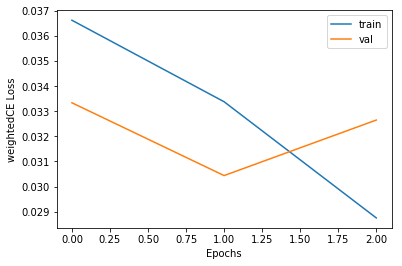

EPOCH: 4 INSTANCE: 1
weighted CE LOSS: 0.029553179

EPOCH: 4 INSTANCE: 2
weighted CE LOSS: 4.3733967e-06

EPOCH: 4 INSTANCE: 3
weighted CE LOSS: 2.7354588e-06

EPOCH: 4 INSTANCE: 4
weighted CE LOSS: 0.08403889

EPOCH: 4 INSTANCE: 5
weighted CE LOSS: 2.7491194e-06

EPOCH: 4 INSTANCE: 6
weighted CE LOSS: 0.00013808465

EPOCH: 4 INSTANCE: 7
weighted CE LOSS: 2.1096032e-06

EPOCH: 4 INSTANCE: 8
weighted CE LOSS: 0.012478809

EPOCH: 4 INSTANCE: 9
weighted CE LOSS: 0.033450425

EPOCH: 4 INSTANCE: 10
weighted CE LOSS: 2.5790378e-06

EPOCH: 4 INSTANCE: 11
weighted CE LOSS: 2.838051e-06

EPOCH: 4 INSTANCE: 12
weighted CE LOSS: 0.0008659339

EPOCH: 4 INSTANCE: 13
weighted CE LOSS: 0.06853122

EPOCH: 4 INSTANCE: 14
weighted CE LOSS: 0.04191527

EPOCH: 4 INSTANCE: 15
weighted CE LOSS: 1.30148355e-05

EPOCH: 4 INSTANCE: 16
weighted CE LOSS: 3.662279e-05

EPOCH: 4 INSTANCE: 17
weighted CE LOSS: 0.058814686

EPOCH: 4 INSTANCE: 18
weighted CE LOSS: 0.003596755

EPOCH: 4 INSTANCE: 19
weighted CE LOSS: 

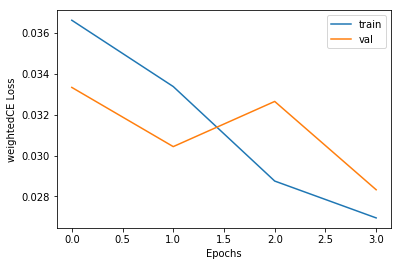

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Segmentor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


EPOCH: 5 INSTANCE: 1
weighted CE LOSS: 0.05755203

EPOCH: 5 INSTANCE: 2
weighted CE LOSS: 6.3831154e-05

EPOCH: 5 INSTANCE: 3
weighted CE LOSS: 0.04653242

EPOCH: 5 INSTANCE: 4
weighted CE LOSS: 0.00016661575

EPOCH: 5 INSTANCE: 5
weighted CE LOSS: 0.053563338

EPOCH: 5 INSTANCE: 6
weighted CE LOSS: 0.050846692

EPOCH: 5 INSTANCE: 7
weighted CE LOSS: 0.06960377

EPOCH: 5 INSTANCE: 8
weighted CE LOSS: 0.064798124

EPOCH: 5 INSTANCE: 9
weighted CE LOSS: 0.054913025

EPOCH: 5 INSTANCE: 10
weighted CE LOSS: 1.5003205e-05

EPOCH: 5 INSTANCE: 11
weighted CE LOSS: 3.593581e-06

EPOCH: 5 INSTANCE: 12
weighted CE LOSS: 0.012677798

EPOCH: 5 INSTANCE: 13
weighted CE LOSS: 0.0009611566

EPOCH: 5 INSTANCE: 14
weighted CE LOSS: 0.0086098295

EPOCH: 5 INSTANCE: 15
weighted CE LOSS: 0.00022367475

EPOCH: 5 INSTANCE: 16
weighted CE LOSS: 0.026360922

EPOCH: 5 INSTANCE: 17
weighted CE LOSS: 0.00020242103

EPOCH: 5 INSTANCE: 18
weighted CE LOSS: 0.055334523

EPOCH: 5 INSTANCE: 19
weighted CE LOSS: 0.000

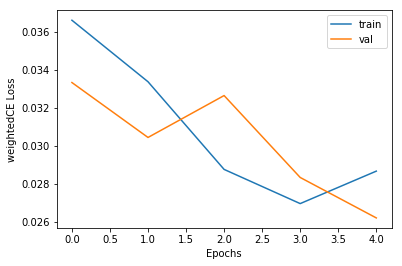

EPOCH: 6 INSTANCE: 1
weighted CE LOSS: 0.0006582243

EPOCH: 6 INSTANCE: 2
weighted CE LOSS: 0.033896014

EPOCH: 6 INSTANCE: 3
weighted CE LOSS: 4.624872e-06

EPOCH: 6 INSTANCE: 4
weighted CE LOSS: 0.002335904

EPOCH: 6 INSTANCE: 5
weighted CE LOSS: 1.1373595e-05

EPOCH: 6 INSTANCE: 6
weighted CE LOSS: 0.00016972958

EPOCH: 6 INSTANCE: 7
weighted CE LOSS: 0.0020847325

EPOCH: 6 INSTANCE: 8
weighted CE LOSS: 1.5161208e-05

EPOCH: 6 INSTANCE: 9
weighted CE LOSS: 0.035834312

EPOCH: 6 INSTANCE: 10
weighted CE LOSS: 8.642731e-06

EPOCH: 6 INSTANCE: 11
weighted CE LOSS: 0.04080207

EPOCH: 6 INSTANCE: 12
weighted CE LOSS: 0.04685664

EPOCH: 6 INSTANCE: 13
weighted CE LOSS: 1.7932622e-05

EPOCH: 6 INSTANCE: 14
weighted CE LOSS: 1.0456384e-05

EPOCH: 6 INSTANCE: 15
weighted CE LOSS: 0.020265901

EPOCH: 6 INSTANCE: 16
weighted CE LOSS: 6.405703e-06

EPOCH: 6 INSTANCE: 17
weighted CE LOSS: 5.7263536e-05

EPOCH: 6 INSTANCE: 18
weighted CE LOSS: 0.00086062885

EPOCH: 6 INSTANCE: 19
weighted CE LOSS

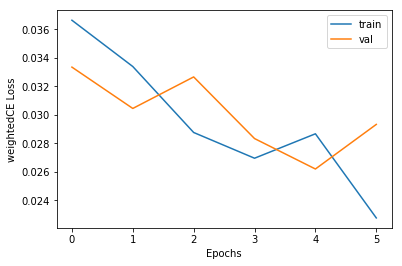

EPOCH: 7 INSTANCE: 1
weighted CE LOSS: 1.2354049e-07

EPOCH: 7 INSTANCE: 2
weighted CE LOSS: 0.02622721

EPOCH: 7 INSTANCE: 3
weighted CE LOSS: 1.5254034e-06

EPOCH: 7 INSTANCE: 4
weighted CE LOSS: 1.4393902e-07

EPOCH: 7 INSTANCE: 5
weighted CE LOSS: 1.0049839e-06

EPOCH: 7 INSTANCE: 6
weighted CE LOSS: 6.6563405e-07

EPOCH: 7 INSTANCE: 7
weighted CE LOSS: 8.773578e-07

EPOCH: 7 INSTANCE: 8
weighted CE LOSS: 0.05458565

EPOCH: 7 INSTANCE: 9
weighted CE LOSS: 0.0037304622

EPOCH: 7 INSTANCE: 10
weighted CE LOSS: 0.062867075

EPOCH: 7 INSTANCE: 11
weighted CE LOSS: 9.319508e-08

EPOCH: 7 INSTANCE: 12
weighted CE LOSS: 0.020643415

EPOCH: 7 INSTANCE: 13
weighted CE LOSS: 0.02266554

EPOCH: 7 INSTANCE: 14
weighted CE LOSS: 0.00035230626

EPOCH: 7 INSTANCE: 15
weighted CE LOSS: 7.427933e-08

EPOCH: 7 INSTANCE: 16
weighted CE LOSS: 0.0005616465

EPOCH: 7 INSTANCE: 17
weighted CE LOSS: 5.1293796e-08

EPOCH: 7 INSTANCE: 18
weighted CE LOSS: 4.847356e-07

EPOCH: 7 INSTANCE: 19
weighted CE LOSS

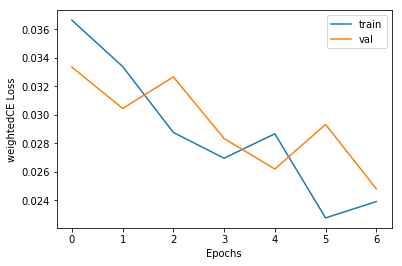

EPOCH: 8 INSTANCE: 1
weighted CE LOSS: 2.1852934e-07

EPOCH: 8 INSTANCE: 2
weighted CE LOSS: 0.056412347

EPOCH: 8 INSTANCE: 3
weighted CE LOSS: 0.00030132974

EPOCH: 8 INSTANCE: 4
weighted CE LOSS: 0.060255785

EPOCH: 8 INSTANCE: 5
weighted CE LOSS: 0.06699859

EPOCH: 8 INSTANCE: 6
weighted CE LOSS: 0.024625931

EPOCH: 8 INSTANCE: 7
weighted CE LOSS: 0.05027958

EPOCH: 8 INSTANCE: 8
weighted CE LOSS: 0.029528327

EPOCH: 8 INSTANCE: 9
weighted CE LOSS: 0.045029927

EPOCH: 8 INSTANCE: 10
weighted CE LOSS: 0.032990545

EPOCH: 8 INSTANCE: 11
weighted CE LOSS: 1.165513e-06

EPOCH: 8 INSTANCE: 12
weighted CE LOSS: 0.03917132

EPOCH: 8 INSTANCE: 13
weighted CE LOSS: 2.4950571e-08

EPOCH: 8 INSTANCE: 14
weighted CE LOSS: 1.0751573e-06

EPOCH: 8 INSTANCE: 15
weighted CE LOSS: 5.3668067e-05

EPOCH: 8 INSTANCE: 16
weighted CE LOSS: 5.150761e-06

EPOCH: 8 INSTANCE: 17
weighted CE LOSS: 0.051334526

EPOCH: 8 INSTANCE: 18
weighted CE LOSS: 0.105928

EPOCH: 8 INSTANCE: 19
weighted CE LOSS: 7.243463e

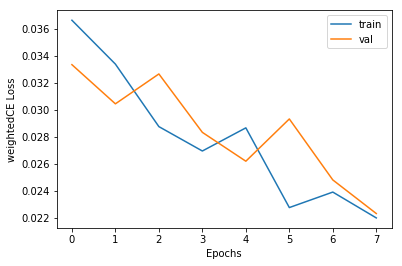

EPOCH: 9 INSTANCE: 1
weighted CE LOSS: 0.049850915

EPOCH: 9 INSTANCE: 2
weighted CE LOSS: 0.070183635

EPOCH: 9 INSTANCE: 3
weighted CE LOSS: 0.048482623

EPOCH: 9 INSTANCE: 4
weighted CE LOSS: 0.027521737

EPOCH: 9 INSTANCE: 5
weighted CE LOSS: 0.031142103

EPOCH: 9 INSTANCE: 6
weighted CE LOSS: 0.019623483

EPOCH: 9 INSTANCE: 7
weighted CE LOSS: 0.039616082

EPOCH: 9 INSTANCE: 8
weighted CE LOSS: 1.4238411e-07

EPOCH: 9 INSTANCE: 9
weighted CE LOSS: 2.0708165e-05

EPOCH: 9 INSTANCE: 10
weighted CE LOSS: 0.023504362

EPOCH: 9 INSTANCE: 11
weighted CE LOSS: 1.8690393e-08

EPOCH: 9 INSTANCE: 12
weighted CE LOSS: 8.629978e-05

EPOCH: 9 INSTANCE: 13
weighted CE LOSS: 0.027084624

EPOCH: 9 INSTANCE: 14
weighted CE LOSS: 0.05524004

EPOCH: 9 INSTANCE: 15
weighted CE LOSS: 0.035294153

EPOCH: 9 INSTANCE: 16
weighted CE LOSS: 1.5128739e-05

EPOCH: 9 INSTANCE: 17
weighted CE LOSS: 1.5579651e-06

EPOCH: 9 INSTANCE: 18
weighted CE LOSS: 8.005692e-05

EPOCH: 9 INSTANCE: 19
weighted CE LOSS: 0.00

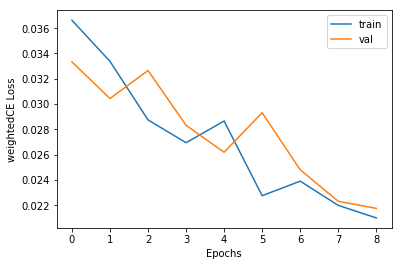

EPOCH: 10 INSTANCE: 1
weighted CE LOSS: 0.027554287

EPOCH: 10 INSTANCE: 2
weighted CE LOSS: 0.050163537

EPOCH: 10 INSTANCE: 3
weighted CE LOSS: 0.018714035

EPOCH: 10 INSTANCE: 4
weighted CE LOSS: 2.4299857e-06

EPOCH: 10 INSTANCE: 5
weighted CE LOSS: 0.031767905

EPOCH: 10 INSTANCE: 6
weighted CE LOSS: 0.04824578

EPOCH: 10 INSTANCE: 7
weighted CE LOSS: 0.020170499

EPOCH: 10 INSTANCE: 8
weighted CE LOSS: 0.035389088

EPOCH: 10 INSTANCE: 9
weighted CE LOSS: 0.019289251

EPOCH: 10 INSTANCE: 10
weighted CE LOSS: 0.04656763

EPOCH: 10 INSTANCE: 11
weighted CE LOSS: 1.0451657e-07

EPOCH: 10 INSTANCE: 12
weighted CE LOSS: 0.04174624

EPOCH: 10 INSTANCE: 13
weighted CE LOSS: 0.024478743

EPOCH: 10 INSTANCE: 14
weighted CE LOSS: 2.125486e-08

EPOCH: 10 INSTANCE: 15
weighted CE LOSS: 0.00010891055

EPOCH: 10 INSTANCE: 16
weighted CE LOSS: 1.8567264e-06

EPOCH: 10 INSTANCE: 17
weighted CE LOSS: 1.1956985e-08

EPOCH: 10 INSTANCE: 18
weighted CE LOSS: 0.022922551

EPOCH: 10 INSTANCE: 19
weight

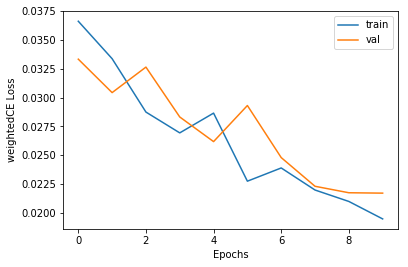

In [31]:
model.train()
for epoch in range(epochs):
    instanceLoss=[]
    for i, data in enumerate(train_ds):
        inputs, target, count=data
        
        # pass inputs into the model
        pred=model(Variable(inputs).cuda())
        
        # calculate class frequency: lesion size/total image size
        classFreq=(count.numpy()/(inputs.shape[-1]*inputs.shape[-2]))
    
        # class weights: 1/freq
        class_weights=torch.FloatTensor([1/(1-classFreq),1/classFreq]).cuda()
        
        # calculate the loss b/w target and prediction using weights
        loss=lossFN(pred,target.long().cuda(),class_weights)
        
        # backprop the gradient
        loss.backward()
    
        instanceLoss.append(loss.data.cpu())
        
        # do a optimisation step
        opt.step()
        opt.zero_grad()
    
        print('EPOCH:',epoch+1,'INSTANCE:',i+1)
        print( 'weighted CE LOSS:',loss.data.cpu().numpy())
        print()
    

    trainLoss.append(sum(instanceLoss)/len(instanceLoss))  
    valLoss.append(checkValidationSet(model,val_ds))
  
    #plot losses
    plt.plot(trainLoss, label='train')
    plt.plot(valLoss, label='val')
    plt.xlabel('Epochs')
    plt.ylabel('weightedCE Loss')
    plt.legend()
    plt.show()
    
    # save trained model every 3 epochs
    if epoch%3==0 and epoch!=0:
        torch.save(model,path+'WeightedModelchkpt'+str(epoch))

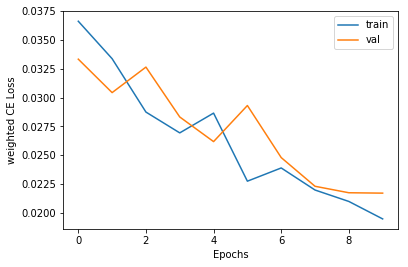

In [32]:
plt.plot(trainLoss, label='train')
plt.plot(valLoss, label='val')
plt.xlabel('Epochs')
plt.ylabel('weighted CE Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


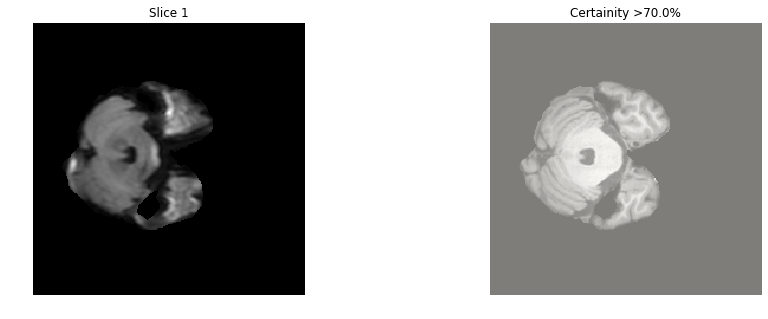

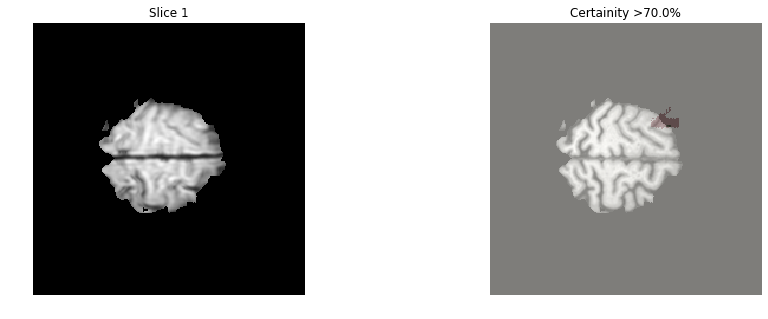

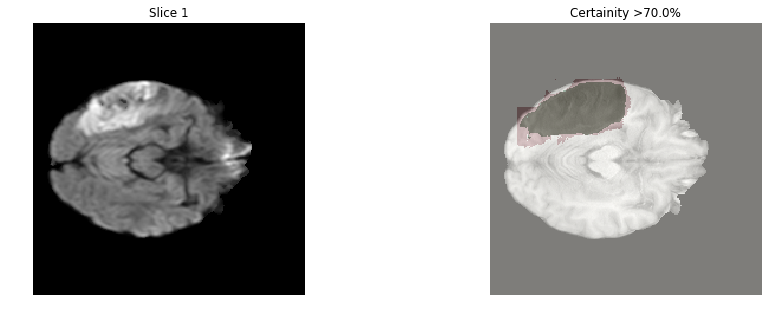

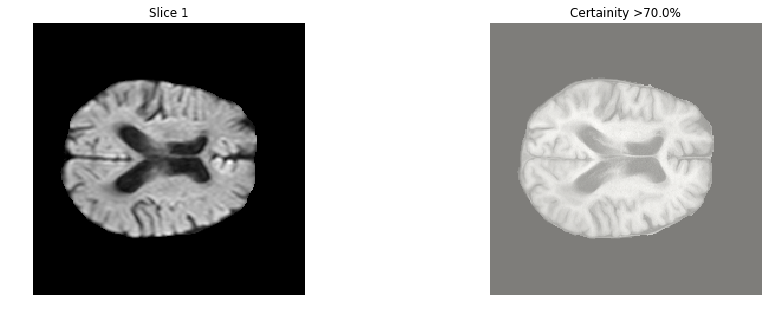

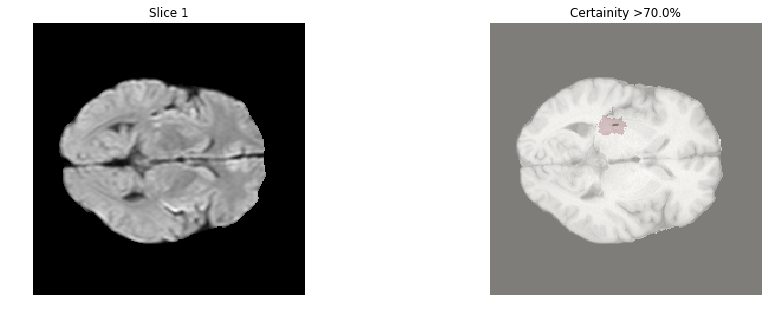

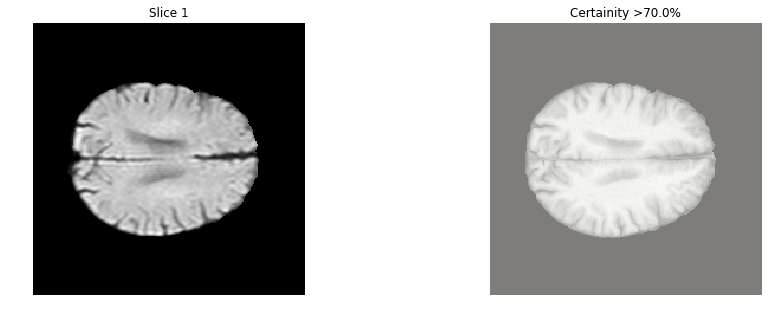

In [33]:
# visualise results and metrics for 5 training set examples
model.eval()
for i, data in enumerate(train_ds):
    inputs, target, count=data
    pred=model(Variable(inputs).cuda())
    
    certainity = 0.7
    # input plots
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Slice 1')
    plt.imshow(inputs[0,0,:,:,],cmap='gray')
    plt.axis('off')
    
    seg=nn.Softmax()(pred).data[0][1]
    SegNumpy=seg.cpu().numpy()
    
    # overlap and uncertaininty
    plt.subplot(122)
    plt.title('Certainity >'+str(certainity*100)+'%')
    plt.imshow(inputs[0,2,:,:,],cmap='gray')
    plt.imshow(SegNumpy>certainity,cmap='Reds',alpha=0.3)
    plt.imshow(target[0,0,:,:],cmap='Greens',alpha=0.3)
    plt.axis('off')
    
    if i >4:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


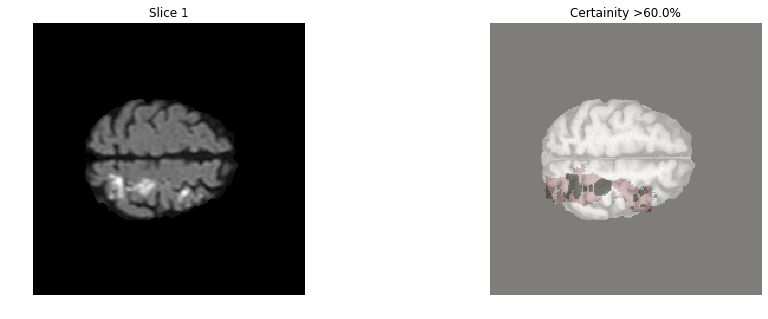

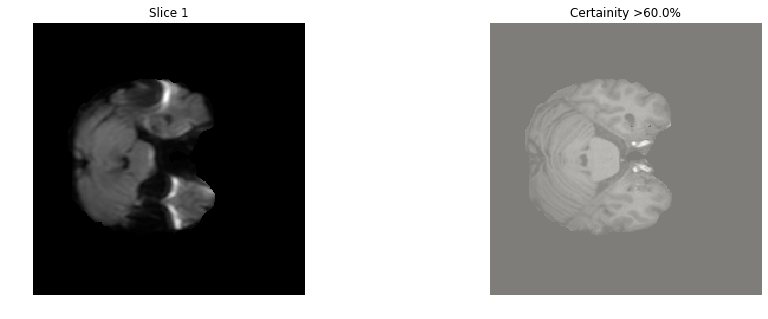

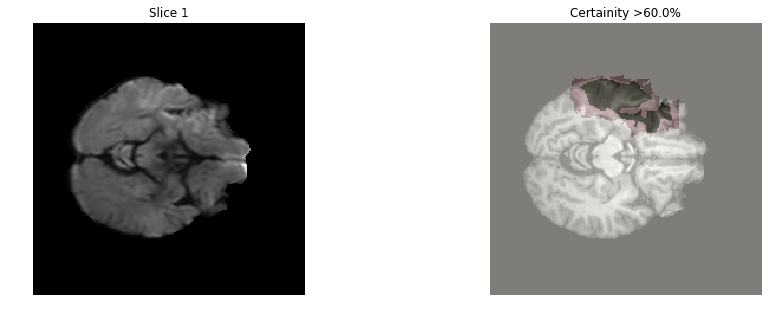

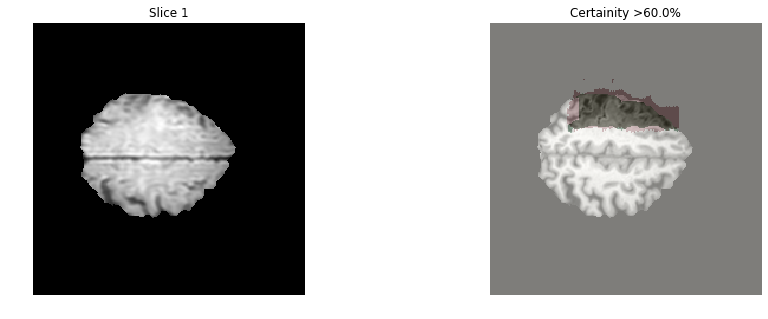

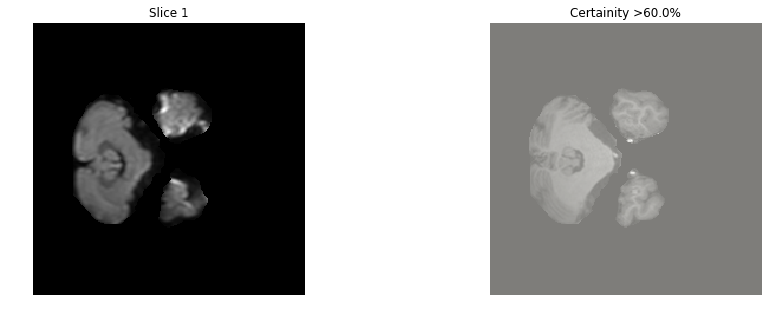

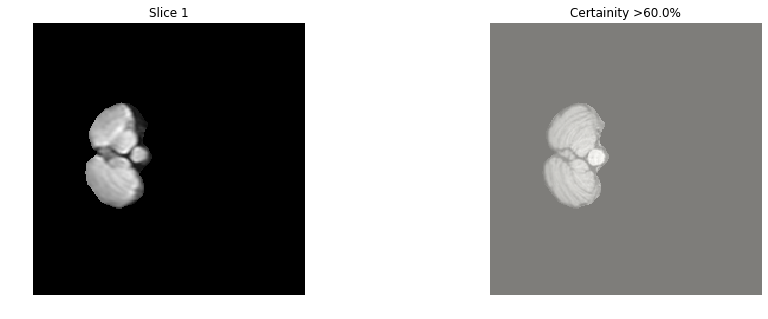

In [35]:
# visualise results and metrics for 5 validation set examples
model.eval()
for i, data in enumerate(val_ds):
    inputs, target, count=data
    pred=model(Variable(inputs).cuda())
    
    certainity = 0.6
    # input plots
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Slice 1')
    plt.imshow(inputs[0,0,:,:,],cmap='gray')
    plt.axis('off')
    
    seg=nn.Softmax()(pred).data[0][1]
    SegNumpy=seg.cpu().numpy()
    
    # overlap and uncertaininty
    plt.subplot(122)
    plt.title('Certainity >'+str(certainity*100)+'%')
    plt.imshow(inputs[0,2,:,:,],cmap='gray')
    plt.imshow(SegNumpy>certainity,cmap='Reds',alpha=0.3)
    plt.imshow(target[0,0,:,:],cmap='Greens',alpha=0.3)
    plt.axis('off')
    
    if i >4:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


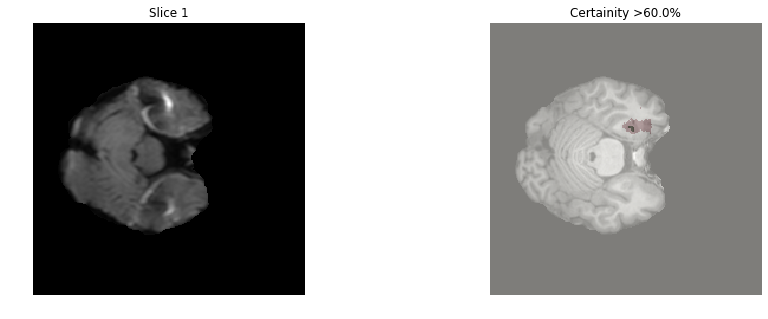

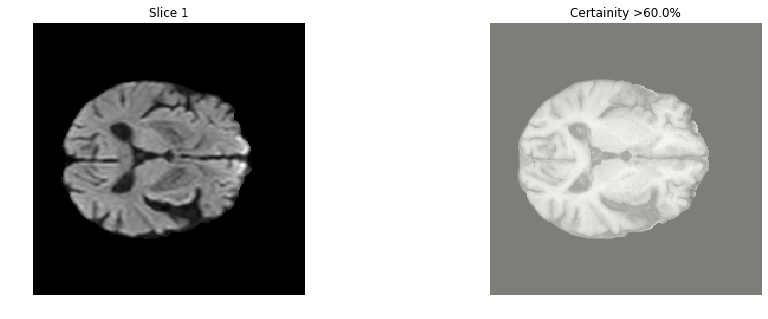

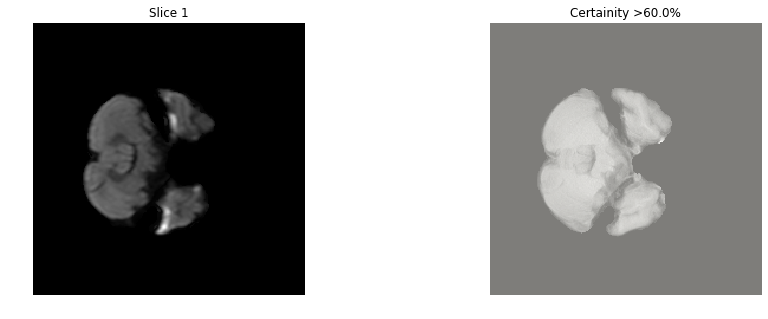

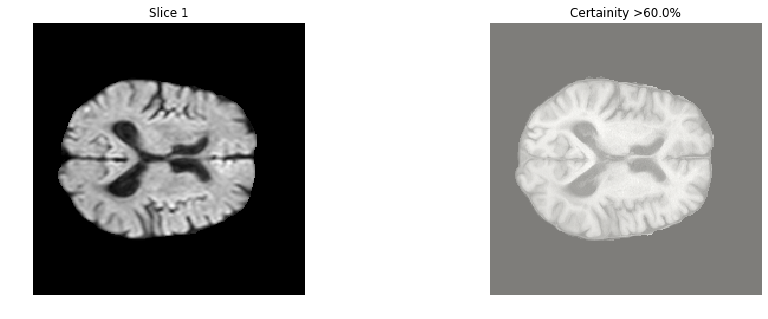

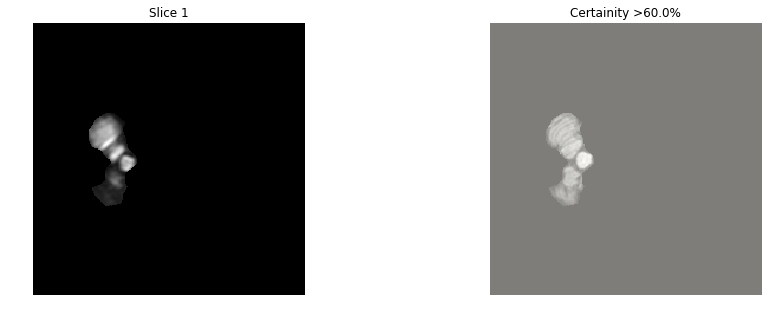

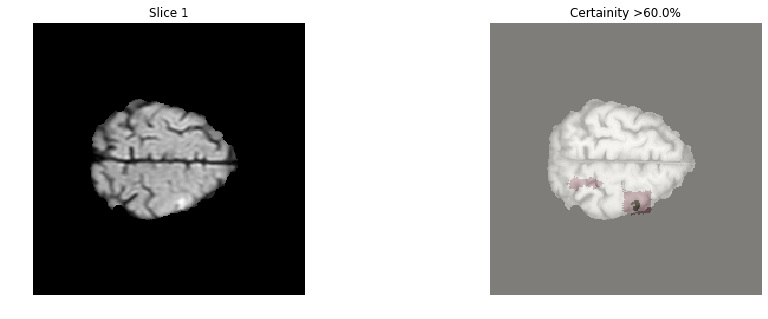

In [34]:
# visualise results and metrics for 5 test set examples
model.eval()
for i, data in enumerate(test_ds):
    inputs, target, count=data
    pred=model(Variable(inputs).cuda())
    
    certainity = 0.6
    # input plots
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.title('Slice 1')
    plt.imshow(inputs[0,0,:,:,],cmap='gray')
    plt.axis('off')
    
    seg=nn.Softmax()(pred).data[0][1]
    SegNumpy=seg.cpu().numpy()
    
    # overlap and uncertaininty
    plt.subplot(122)
    plt.title('Certainity >'+str(certainity*100)+'%')
    plt.imshow(inputs[0,2,:,:,],cmap='gray')
    plt.imshow(SegNumpy>certainity,cmap='Reds',alpha=0.3)
    plt.imshow(target[0,0,:,:],cmap='Greens',alpha=0.3)
    plt.axis('off')
    
    if i >4:
        break